## SKlearn NFM

#### Lets run SKLearn's NMF algorithm on a small 2d sample array

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.preprocessing import normalize

In [2]:
# generates a matrix of N x N w/ values (1-10)
def generateV(N=25):
    return 10 * np.random.random_sample((N, N))

In [3]:
def compareNMFtoPCA(V):
    Vn = np.array(V)
    F = len(V[0]) # feature count
    pair_matrices = []
    df = []
    for i in range(F,1,-1):
        p = PCA(n_components=i).fit(Vn).components_
        pairs = [[0]*i]*i 
        w, h = my_nmf(pd.DataFrame(V), i)
        sum = 0.0        
        for nmf_i in range(i):
            for pca_i in range(i):
                sum += correlate(w[nmf_i], p[pca_i])
                pairs[nmf_i][pca_i] = correlate(w[nmf_i], p[pca_i])
        df.append([(sum / i)])
        pair_matrices.append(pairs)
            
    return pd.DataFrame(df, columns=["Correlation"]), pair_matrices

In [4]:
def my_nmf(input_df, n_components, learn_iter=200):
    input_matrix = input_df.to_numpy().T
    activations = np.random.rand(n_components, input_matrix.shape[1])
    basis_vectors = np.random.rand(input_matrix.shape[0], n_components)
    ones = np.ones(input_matrix.shape)  
    basis_vectors = normalize(basis_vectors)
    
    for _ in range(learn_iter):
        activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
        basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
    
        basis_vectors = normalize(basis_vectors)
    

    return basis_vectors.T, activations.T

In [22]:
class OurNMF:
    def __init__(self, n_components, learn_iter=200):
        self.n_components_ = n_components
        self.learn_iter_ = learn_iter
        
    # Private method - core functionality
    def __nmf(self, input_df):
        input_matrix = input_df.to_numpy().T
        activations = np.random.rand(self.n_components_, input_matrix.shape[1])
        basis_vectors = np.random.rand(input_matrix.shape[0], self.n_components_)
        basis_vectors = normalize(basis_vectors)
        ones = np.ones(input_matrix.shape)
    
        for i in range(self.learn_iter_):
            activations *= ((basis_vectors.T @ (input_matrix / (basis_vectors @ activations))) / (basis_vectors.T @ ones))
            basis_vectors *= (((input_matrix / (basis_vectors @ activations)) @ activations.T) / (ones @ activations.T))
            
            activations = np.nan_to_num(activations)
            basis_vectors = np.nan_to_num(basis_vectors)
#             print(basis_vectors.dtype)
#             print(True in np.isnan(basis_vectors))
#             print(True in np.isinf(basis_vectors))
            
            basis_vectors = normalize(basis_vectors)
            
        return basis_vectors.T, activations.T
    
    # Public methods
    # Useless function - similar to scikit-learn, but call fit_transform to get transformed values back
    def fit(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        
    def fit_transform(self, input_df):
        self.basis_vecs_, self.trans_vals_ = self.__nmf(input_df)
        return self.trans_vals_
    
    def test_fit(self, input_df):
        return self.__nmf(input_df)

In [5]:
def correlate(nmf_i, pca_i):
    return pearsonr(nmf_i, pca_i)[0]

We will use the following function to compare our implementation of NMF to SKLearn's implementation of NMF. The function takes as input a size for the starting matrix. The function will then reduce the starting matrix by one dimension and try to approximate the original input matrix. We measure the average error at aproximating the original matrix for both our implementation and SKLearn's NMF. At each dimensionality reduction iteration, a mean average error is recorded for each respective algorithm. We are able to visualize the results by plotting the data.

In [34]:
def compare_error(x_size):
    X = generateV(N=x_size)
    N = X.shape[1]
    err_outs = []
    sk_errs = []
    my_errs = []

    for i in range(N - 1, 2, -1): # inclusive range to N
        skl_nmf = NMF(n_components=i, init='random', solver='mu', beta_loss='kullback-leibler')
        sh = skl_nmf.fit_transform(X)
        sw = skl_nmf.components_
        sv = np.matmul(sw.transpose(), sh.transpose())
        
        our_nmf = OurNMF(n_components=i)
        mw, mh = our_nmf.test_fit(pd.DataFrame(X))
        mv = np.matmul(mw.transpose(), mh.transpose())
        err_corr = 0
        err_my = 0
        err_sk = 0
        cnt = 0.0
        for k in range(len(mv[0])):
            err_sk += mean_squared_error(sv[k], X[k])
            err_my += mean_squared_error(mv[k], X[k])
            err_corr += correlate(mh[k], sh[k])
            cnt += 1
        err_outs.append(err_corr / cnt)
        sk_errs.append(err_sk / cnt)
        my_errs.append(err_my / cnt)
    return my_errs, sk_errs, err_outs

In [35]:
my_errs, sk_errs, err_outs = compare_error(50)

#### Here is our mean_squared_error for modifying n_components in SKLearn's NMF Algorithm

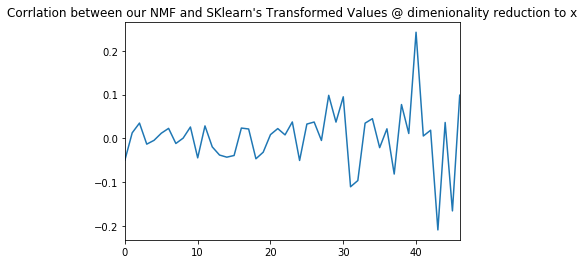

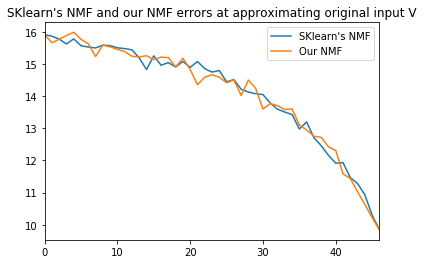

In [36]:
errs_total = pd.DataFrame([sk_errs, my_errs]).transpose()
errs_total.columns = ['SKlearn\'s NMF', 'Our NMF']
# display(pd.DataFrame(err_outs).describe())
pd.Series(err_outs).plot(title="Corrlation between our NMF and SKlearn's Transformed Values @ dimenionality reduction to x")
errs_total.plot(title="SKlearn's NMF and our NMF errors at approximating original input V")

In [37]:
av = generateV()
w, h = my_nmf(pd.DataFrame(av), 2)
nv = np.matmul(w.transpose(),h.transpose())
print("Shape of actual V is {}".format(av.shape))
print("Shape of new V is {}".format(nv.shape))

Shape of actual V is (25, 25)
Shape of new V is (25, 25)


# Testing Accuracy with NMF:

## Comparing to PCA

<img src="screenshots/compare_pca.jpg" alt="Drawing" style="width: 1000px;"/>

We need some way to compare nmf and pca at dimensions higher when reducing to dimensions higher than two. One way to do this is to use a pearson correlation test between pairs of basis vectors from NMF and PCA respectively.  

Below highlights the usgage of scipys pearsonr function which we use to calculate Pearson's correlation coefficient from our nmf and pca basis vectors.

In [38]:
x = [1,2,3,4,5,6,7,8,9,10]
y = [2,4,6,8,10,12,14,16,18,20]
print("Pearson's correlation coefficient = {}".format(((pearsonr(x,y)[0] + pearsonr(y,x) )/ 2)[0]))

Pearson's correlation coefficient = 1.0


Averaging all possible pairs Pearson correlation coefficient

In [14]:
# TODO need NMF model function


V = generateV(N=50)
l_p_vals = compareNMFtoPCA(V) # outputs list of pair matrices containing pearson correlation values for each [ith dimension][nmf_ith basis vector][pca_ith basis vector]
# need to run analysis on above. maybe avg pair correlation values at each iteration?

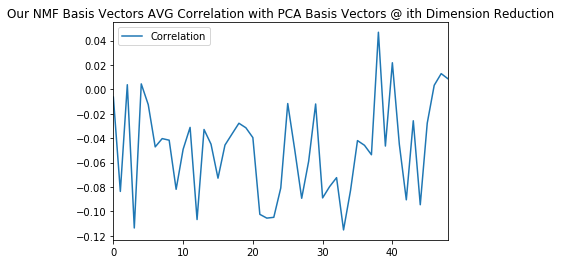

In [18]:
display(l_p_vals[0].plot(title="Our NMF Basis Vectors AVG Correlation with PCA Basis Vectors @ ith Dimension Reduction"))

## Recursive NMF Dimensionality Reduction? 
Do we lose more info in aproximating each step or losing the dimensions?

In [ ]:
def recur_reduce_nmf(V, target, n=2):
    w, h = my_nmf(pd.DataFrame(V), target - 1)
    if(target == n + 1):
        return w, h
    return recur_reduce_nmf(np.matmul(w.transpose(), h.transpose()), target - 1)

In [ ]:
test_v = generateV()
wt, ht = my_nmf(pd.DataFrame(test_v), 2)
wr, hr = recur_reduce_nmf(test_v, len(test_v) - 1)

tV = np.dot(wt, ht)
rV = np.dot(wr, hr)

In [ ]:
pd.DataFrame(wr.transpose()).plot()
pd.DataFrame(wt.transpose()).plot()
pd.DataFrame(hr).plot()
pd.DataFrame(ht).plot()

pd.DataFrame(rV).plot()
pd.DataFrame(tV).plot()

# Clustering our PCA and NMF transformed V